In [82]:
from mesa import Agent, Model
from mesa.time import RandomActivation
import random 
%matplotlib inline
import matplotlib.pyplot as plt
from mesa.space import MultiGrid
import numpy as np
from mesa.datacollection import DataCollector
from mesa.batchrunner import BatchRunner

In [67]:
def compute_gini(model):
    agent_wealths = [agent.wealth for agent in model.schedule.agents]
    x = sorted(agent_wealths)
    N = model.num_agents
    B = sum( xi * (N-i) for i,xi in enumerate(x) ) / (N*sum(x))
    return (1 + (1/N) - 2*B)

In [83]:
class MoneyAgent(Agent):
    """ An agent with fixed initial wealth."""
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.wealth = 1

    def move(self):
        possible_steps = self.model.grid.get_neighborhood(
            self.pos,
            moore=True,
            include_center=False)
        new_position = random.choice(possible_steps)
        self.model.grid.move_agent(self, new_position)

    def give_money(self):
        cellmates = self.model.grid.get_cell_list_contents([self.pos])
        if len(cellmates) > 1:
            other = random.choice(cellmates)
            other.wealth += 1
            self.wealth -= 1

    def step(self):
        self.move()
        if self.wealth > 0:
            self.give_money()
        
class MoneyModel(Model):
    """A model with some number of agents."""
    def __init__(self, N, width, height):
        self.num_agents = N
        self.grid = MultiGrid(width, height, True)
        self.schedule = RandomActivation(self)
        self.running = True

        # Create agents
        for i in range(self.num_agents):
            a = MoneyAgent(i, self)
            self.schedule.add(a)
            # Add the agent to a random grid cell
            x = random.randrange(self.grid.width)
            y = random.randrange(self.grid.height)
            self.grid.place_agent(a, (x, y))

        self.datacollector = DataCollector(
            model_reporters={"Gini": compute_gini},
            agent_reporters={"Wealth": lambda a: a.wealth})

    def step(self):
        self.datacollector.collect(self)
        self.schedule.step()

In [32]:
#empty_model = MoneyModel(10)
#empty_model.step()

(array([ 24.,   0.,  12.,   0.,   0.,   7.,   0.,   4.,   0.,   3.]),
 array([ 0. ,  0.4,  0.8,  1.2,  1.6,  2. ,  2.4,  2.8,  3.2,  3.6,  4. ]),
 <a list of 10 Patch objects>)

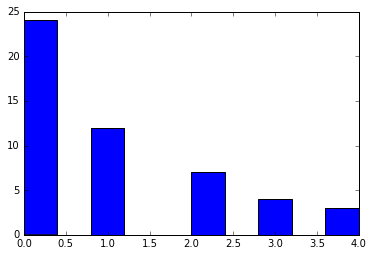

In [70]:
agent_wealth = [a.wealth for a in model.schedule.agents]
plt.hist(agent_wealth)

In [71]:
all_wealth = []
for j in range(100):
    # Run the model
    model = MoneyModel(10)
    for i in range(10):
        model.step()

    # Store the results
    for agent in model.schedule.agents:
        all_wealth.append(agent.wealth)

plt.hist(all_wealth, bins=range(max(all_wealth)+1))

TypeError: __init__() missing 2 required positional arguments: 'width' and 'height'

In [72]:
model = MoneyModel(50, 10, 10)
for i in range(20):
    model.step()

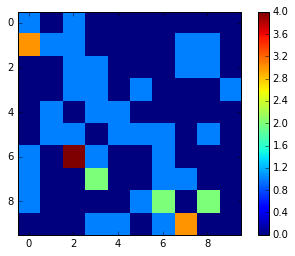

In [73]:
agent_counts = np.zeros((model.grid.width, model.grid.height))
for cell in model.grid.coord_iter():
    cell_content, x, y = cell
    agent_count = len(cell_content)
    agent_counts[x][y] = agent_count
plt.imshow(agent_counts, interpolation='nearest')
plt.colorbar()

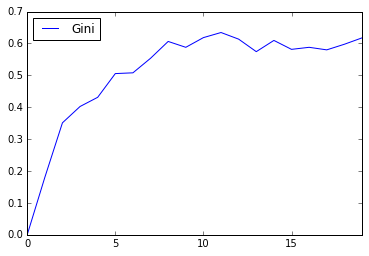

In [74]:
gini = model.datacollector.get_model_vars_dataframe()
gini.plot()

In [75]:
gini.head()

,Gini
0,0.0000
1,0.1800
2,0.3512
3,0.4024
4,0.4312


In [76]:
agent_wealth = model.datacollector.get_agent_vars_dataframe()
agent_wealth.head(5)

Wealth
Step AgentID        
0    0             1
     1             1
     2             1
     3             1
     4             1

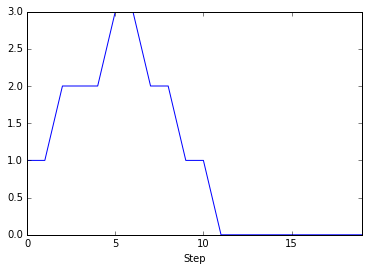

In [80]:
one_agent_wealth = agent_wealth.xs(20, level="AgentID")
one_agent_wealth.Wealth.plot()

In [84]:
parameters = {"width": 10,
              "height": 10,
              "N": range(10, 500, 10)}

batch_run = BatchRunner(MoneyModel,
                        parameters,
                        iterations=5,
                        max_steps=100,
                        model_reporters={"Gini": compute_gini})
batch_run.run_all()

100%|██████████| 245/245 [02:29<00:00,  1.05s/it]


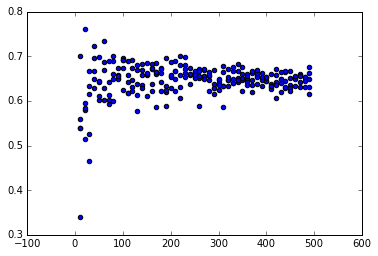

In [85]:
run_data = batch_run.get_model_vars_dataframe()
run_data.head()
plt.scatter(run_data.N, run_data.Gini)